# Initial model building with all parameters

Trying to do density-based clustering

In [287]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)



#### Loading data

In [288]:
compData = pd.read_csv('../CRM data/compData.csv',sep=',')
crmData = pd.read_csv('../CRM data/full_data.csv',sep=',')

#### Pick a model (crmData or complete data (incl. env. impacts params))

Normalises the data with Min-Max scaling (0-1) 

In [289]:
def make_model(data):
    if len(data.columns) == 5:
        model = data[['Material','EOLR','SR','EI']]
        numCols = ['EOLR','SR','EI']
    else:
        model = data[['Material','aEHP','EGov','GSMEF','EOLR','SR','EI']]
        numCols = ['aEHP','EGov','GSMEF','EOLR','SR','EI']
    scaler = MinMaxScaler()
    model.loc[:,numCols] = scaler.fit_transform(model[numCols]).round(3)
    return model

In [301]:
crmmodel = make_model(crmData)
crmmodel = make_model(crmData[(crmData['SR']>=1.0) &(crmData['EI']>=1.0)])
numCols = ['EOLR','SR','EI']
#compmodel, numCols = make_model(compData)

In [302]:
# Old
### compmodel = compData[(compData['SR']>=1.0) &(compData['EI']>=1.0)]

#### Testing out density-based clustering

In [303]:
dbscan = DBSCAN(eps=0.25, min_samples=3)
crmmodel['Cluster'] = dbscan.fit_predict(crmmodel[numCols])
print(crmmodel['Cluster'].value_counts())


Cluster
 2    22
 0     5
-1     3
 1     3
 3     3
Name: count, dtype: int64


In [304]:
epsVal = np.arange(0.05,0.6,0.02)
samples = [i for i in range(1,20,1)]

best_score = -1
best_eps = None
best_min_samples = None

# Loop through different combinations of eps and min_samples
for eps in epsVal:
    for min_samples in samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(crmmodel[numCols])
        
        # Avoid silhouette score calculation when all points are noise (-1)
        if len(set(clusters)) > 1:  # More than 1 unique cluster (excluding noise)
            score = silhouette_score(crmmodel[numCols], clusters)
            #print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score}")
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best parameters: eps = {best_eps}, min_samples = {best_min_samples}, with Silhouette Score: {best_score}")

Best parameters: eps = 0.3500000000000001, min_samples = 5, with Silhouette Score: 0.4697036959250874


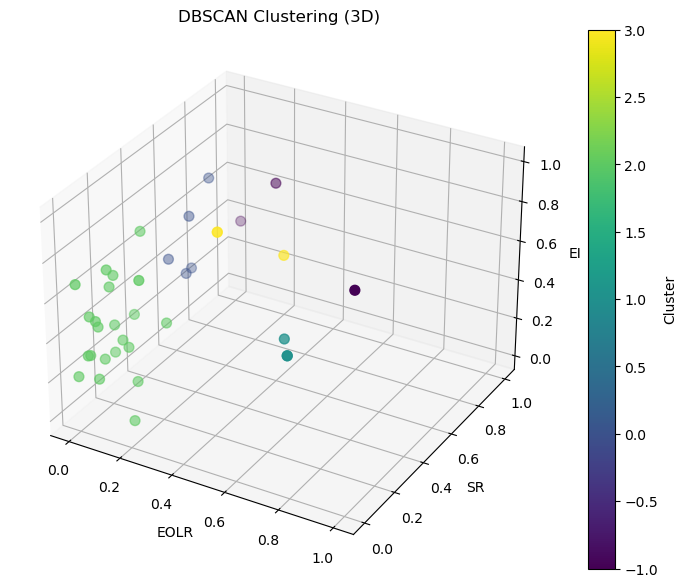

In [305]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # No need to explicitly import Axes3D

# Select the columns for 3D scatter plot
x = crmmodel['EOLR']  # X-axis (EOLR)
y = crmmodel['SR']    # Y-axis (SR)
z = crmmodel['EI']    # Z-axis (EI)

# Scatter plot with cluster color coding
sc = ax.scatter(x, y, z, c=crmmodel['Cluster'], cmap='viridis', s=50)

# Adding titles and labels
ax.set_title('DBSCAN Clustering (3D)')
ax.set_xlabel('EOLR')
ax.set_ylabel('SR')
ax.set_zlabel('EI')

# Colorbar for clusters
plt.colorbar(sc, label='Cluster')

In [314]:
crmmodel[(crmmodel['Cluster']==-1)|(crmmodel['Cluster']==0)]

,Material,EOLR,SR,EI,Cluster
1,HREE,0.024,1.000,0.366,-1
2,Phosphorus,0.000,0.561,0.437,0
27,Borates,0.024,0.634,0.324,0
28,LREE,0.024,0.659,0.606,0
34,Magnesium,0.310,0.756,0.817,-1
54,Gallium,0.000,0.707,0.296,0
58,Tungsten,1.000,0.049,1.000,-1
60,Niobium,0.000,0.829,0.690,0


In [ ]:
plt.scatter(model['EOLR'], model['SR'], c=model['Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('EOLR')
plt.ylabel('SR')
plt.colorbar(label='Cluster')
plt.show()

#### Creating a criticality weight based on all parameters

- $Criticality = e^{k*(sum of params)}$

- Reasoning: 1 kg of iron is not the same as 1 kg of HREE
- The difference in composition % (e.g 70% iron to 5% HREE) must be adjusted for with weights

In [202]:
def make_criticality_weights(dfcrit):
    k = 3 # Constant
    var = (1-(dfcrit['EOLR'])+dfcrit[['SR','EI']].sum(axis=1)) # Sum of multiple variables
    dfcrit['Criticality'] =  (np.e**(k*var)).round()
    scaler = MinMaxScaler()
    
    #numCols = ['EOLR','SR','EI','Criticality']
    #dfcrit.loc[:,numCols] = scaler.fit_transform(dfcrit[numCols]).round(3) 
    
    dfcrit.loc[:,'Criticality'] = scaler.fit_transform(dfcrit[['Criticality']]).round(3) # Normalise the criticality parameter
    return dfcrit

In [200]:
test_criticality_factor = make_criticality_weights(crmmodel[['Material','EOLR','SR','EI']])
#test_criticality_factor.sort_values(by='Criticality',ascending=False)

#### Testing to calculate composite parameters with some alloys

In [203]:
def merge_alloy_data(material_df,alloy):
    merged_d = pd.merge(material_df,alloy.rename("Composition"), 
                    left_on="Material", 
                    right_index=True, 
                    how="inner")
    return merged_d.astype({'Composition':'float64'})

def convert_dict_to_df(material_dictionary):
    dict_to_df = pd.DataFrame(material_dictionary).fillna(0).T
    return dict_to_df.iloc[1:,0]

    
def calculate_composite_params(df):
    df = df[df['Composition']>0]
    factor = df['Composition']*df['Criticality']
    df_ei = (df['EI']*factor).sum()
    df_sr = (df['SR']*factor).sum()
    df_eol = ((1-df['EOLR'])*factor).sum()

    #df_ehp = (df['aEHP']*factor).sum()
    #df_egov = (df['EGov']*factor).sum()
    #df_gsmef = (df['GSMEF']*factor).sum()
    #return df_ehp.round(3),df_egov.round(3),df_gsmef.round(3),df_eol.round(3), df_sr.round(3), df_ei.round(3), 
    
    return df_eol.round(3), df_sr.round(3), df_ei.round(3), 
    
    


In [189]:
# Data for Nickel-Based Alloys
nickel_alloys_data = {
    "Alloy": ["Inconel 718"],
    "Nickel": [52],
    "Iron_ore": [18],
    "Chromium": [19],
    "Molybdenum": [3],
    "Niobium": [5],
    "Titanium": [1],
    "Cobalt": [1],
}

iron_alloys_data = {
    "Alloy": ["High-Speed Steel (M2)", "Maraging Steel (Grade 300)", "Tungsten Steel"],
    "Iron_ore": [70, 75, 70],
    "Nickel": [0, 18, 0],
    "Tungsten": [6, 0, 25],
    "Cobalt": [8, 9, 5],
    "Chromium": [4, 0, 0],
    "Vanadium": [2, 0, 0],
    "Titanium": [0, 0.6, 0],
    "Molybdenum": [5, 0.3, 0],
    "Carbon": [1, 0, 0],
}

ndfeb_alloy_data = {
    "Alloy": ["NdFeB Magnet"],
    "Iron_ore": [65.0],
    "LREE": [28.0],
    "Borates": [1.0],
    "HREE": [4.0],
    "Cobalt": [2.0],
}


1. Converting to Df objects
2. Merging with model
3. Calculating composite values

In [205]:
# 1
inconel = convert_dict_to_df(nickel_alloys_data)
m2 = convert_dict_to_df(iron_alloys_data)
ndfeb = convert_dict_to_df(ndfeb_alloy_data)

# 2
m2merge = merge_alloy_data(test_criticality_factor,m2)
inco_merge = merge_alloy_data(test_criticality_factor,inconel)
ndfebmerge = merge_alloy_data(test_criticality_factor,ndfeb)

# 3
incocomposite = calculate_composite_params(inco_merge)
m2composite = calculate_composite_params(m2merge)
ndfebcomposite = calculate_composite_params(ndfebmerge)

In [166]:
imean = inco_merge[['EOLR','SR','EI']].mean()
m2mean = m2merge[['EOLR','SR','EI']].mean()
ndfebmean = ndfebmerge[['EOLR','SR','EI']].mean()

In [168]:
incocomposite

(8.261, 4.793, 6.567)

In [170]:
m2composite

(3.596, 1.292, 4.274)

In [172]:
crmData[crmmodel['Material']=='Titanium']

,Material,EOLR,SR,EI,Stage used in SR
50,Titanium,0.01,0.5,5.4,E


In [173]:
ndfebcomposite

(18.208, 12.94, 12.123)

#### Testing to calculate recycling potential of CRM in waste streams as:

- Concentration of CRM in waste stream (PPM) * Amount of waste stream (Tons)

In [281]:
# Zn-industry waste stream

ppm = 10**-6
# Concentrations
#elements = pd.Series(data=['nd','ga','w','dy'])
elements = ['nd','ga','w','dy']
#concentrations = pd.Series(data = [3*ppm,183*ppm,5*ppm,0])

indices = ['ni','cu','zn','al']
CRMconcentrations = [
    [0,23,9,0],
    [23,12,0,2],
    [3,183,5,0],
    [1,112,2,0]
]

CRMconcPPM = [[j*ppm for j in row] for row in CRMconcentrations]

industry_size = [149000,1066000,372000, 159396]

CRMamountsPPM = pd.DataFrame(data=CRMconcPPM ,columns=elements, index=indices)
CRMamounts = pd.DataFrame(data=CRMconcentrations ,columns=elements, index=indices)

industry_size_df = pd.DataFrame(data = [industry_size],columns = indices)
### Now I want to do a df recycling potentials where I multiply each value in CRMamounts matrix, with it's corresponding industry
res = CRMamountsPPM.mul(industry_size_df.iloc[0], axis=0).round()








In [285]:
res*CRMamounts

,nd,ga,w,dy
ni,0.0,69.0,9.0,0.0
cu,575.0,156.0,0.0,4.0
zn,3.0,12444.0,10.0,0.0
al,0.0,2016.0,0.0,0.0


In [267]:
test

[[0.0, 2.3e-05, 9e-06, 0.0],
 [2.3e-05, 1.2e-05, 0.0, 2e-06],
 [3e-06, 0.000183, 4.9999999999999996e-06, 0.0],
 [1e-06, 0.000112, 2e-06, 0.0]]